# Nonlinear Correlation: beyond Spearman

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from pygam import GAM, s

from plotnine import ggplot, geom_point, geom_line, ggtitle, aes

sys.path.append(os.path.relpath('../nonlinear_r/'))

from xicor import xicor

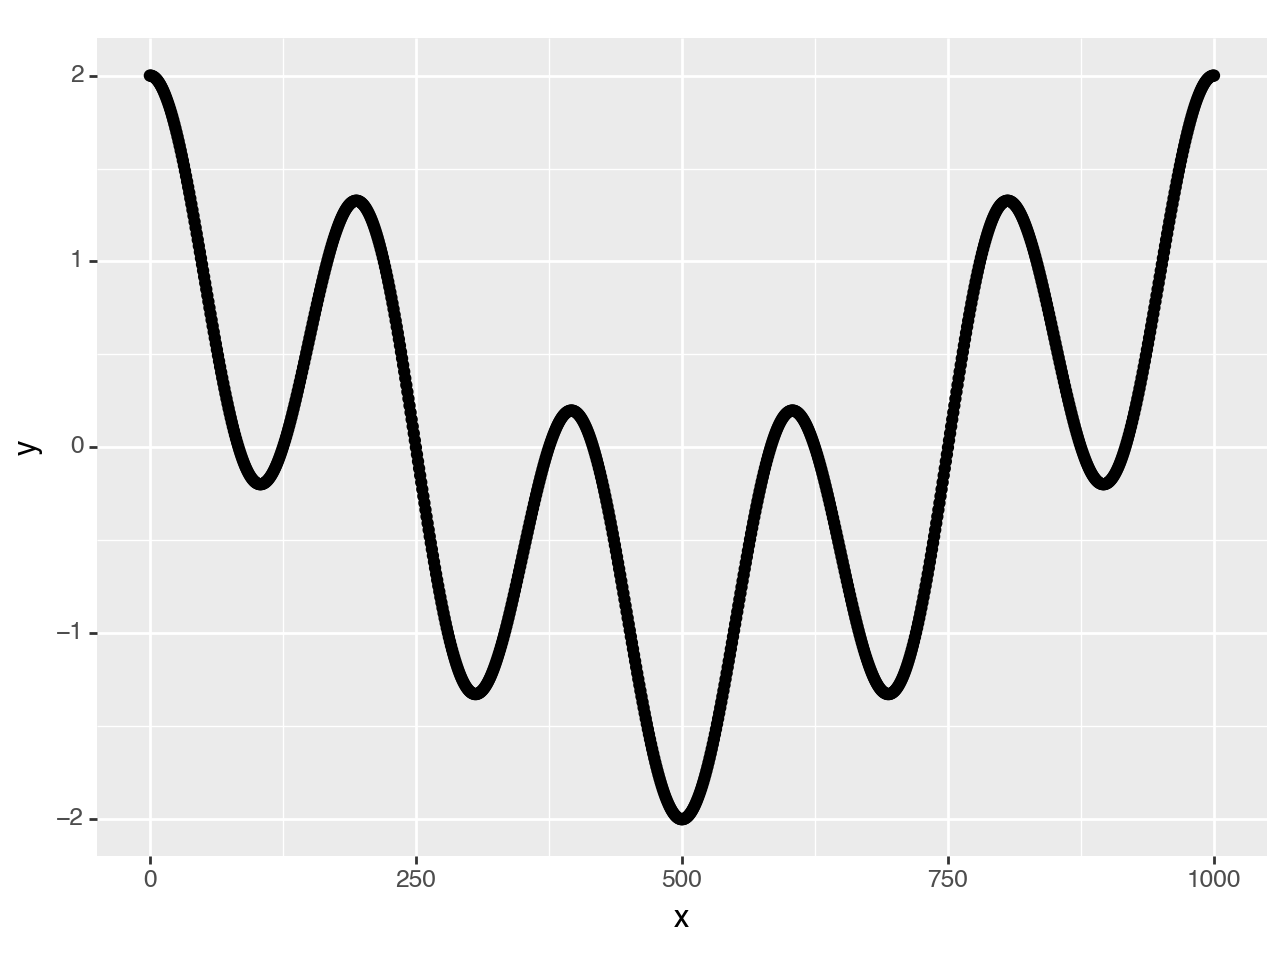

<Figure Size: (640 x 480)>

In [2]:
# Set up: x denotes a predictor and y is a nonlinear function of x

np.random.seed(0)
x = np.arange(1001)
df = pd.DataFrame({'x': x,
                   'y': np.cos(x * np.pi / 100) + 
                        np.cos(x * np.pi / 500)})
ggplot(data=df, mapping=aes(x="x", y="y")) + geom_point()

In [3]:
# Calculate Pearson and Spearman correlation coefficients.
# As expected, these correlations are close to zero

print(f"Rp(x, y) = {pearsonr(df['x'], df['y'])}")
print(f"Rs(x, y) = {spearmanr(df['x'], df['y'])}")

Rp(x, y) = PearsonRResult(statistic=-1.1129220571718668e-16, pvalue=0.9999999999999948)
Rs(x, y) = SignificanceResult(statistic=-0.00012064583207025048, pvalue=0.9969582368382301)


In [4]:
# But we know that y is a deterministic function of x!
# Enter Chatterjee's correlation coefficient, XICOR.
# Unlike Spearman R, XICOR does not assume monotonicity.

print(f"Rs(x, y) = {xicor(df['x'], df['y'])}")

Rs(x, y) = {'statistic': 0.9807934131736527, 'pvalue': 0.0}


In [5]:
# Let us now add noise to y and see what happens to XICOR

# Auxiliary functions, incl. GAM fits for comparison

def add_noise_to_y(y, sd):
    return y + sd * np.random.normal(size=len(y))

def gam_score(x, y, sd):
    z = add_noise_to_y(y, sd)
    return GAM(s(0, n_splines=30)).fit(x, z).score(x, z)

def average_stats(x, y, sd, reps):
    a = [xicor(x, add_noise_to_y(y, sd)) for _ in range(reps)]
    avg_statistic = np.mean([t['statistic'] for t in a])
    avg_pvalue = np.mean([t['pvalue'] for t in a])
    gam_r2 = np.mean([gam_score(x, y, sd) for _ in range(20)])
    return [avg_statistic, avg_pvalue, gam_r2]

def get_stats(x, y, sd):
    a = average_stats(x, y, sd, 2000)
    return pd.DataFrame({
        'noise_sd': sd,
        ' ': ['xicor_statistic', 'xicor_pvalue', 'gam_expl_dev'],
        'value': a})

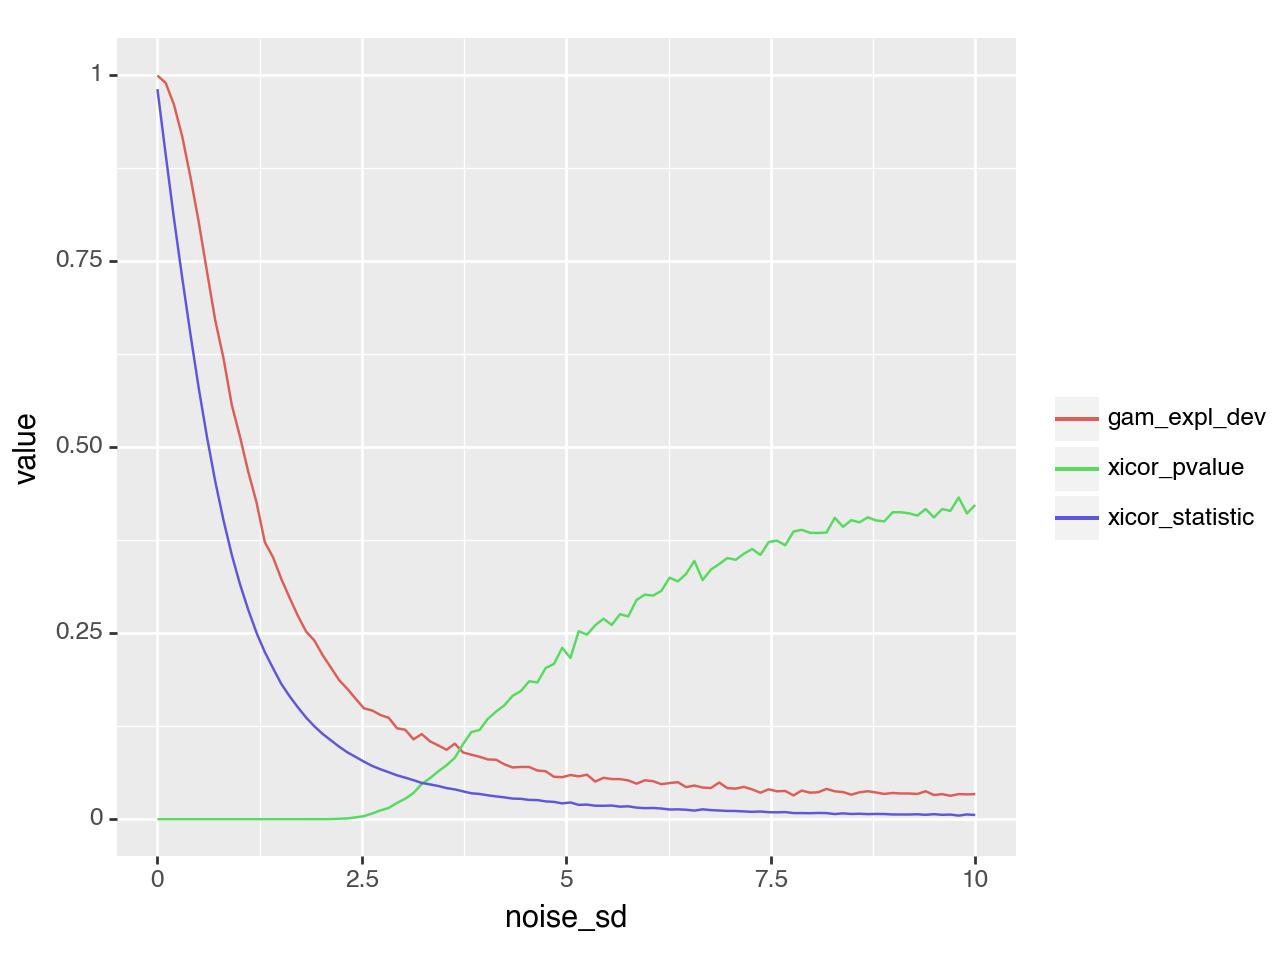

<Figure Size: (640 x 480)>

In [6]:
# As the noise increases, XICOR converges to zero
# GAM explained variance behaves similarly to XICOR

noise_sd = np.linspace(0, 10, 100)
noise_df = pd.concat([get_stats(df['x'], df['y'], sd)
                      for i, sd in enumerate(noise_sd)], 
                     axis=0, ignore_index=True)

ggplot(data=noise_df) + \
    geom_line(aes(x="noise_sd", y="value", color=" ", group=" "))

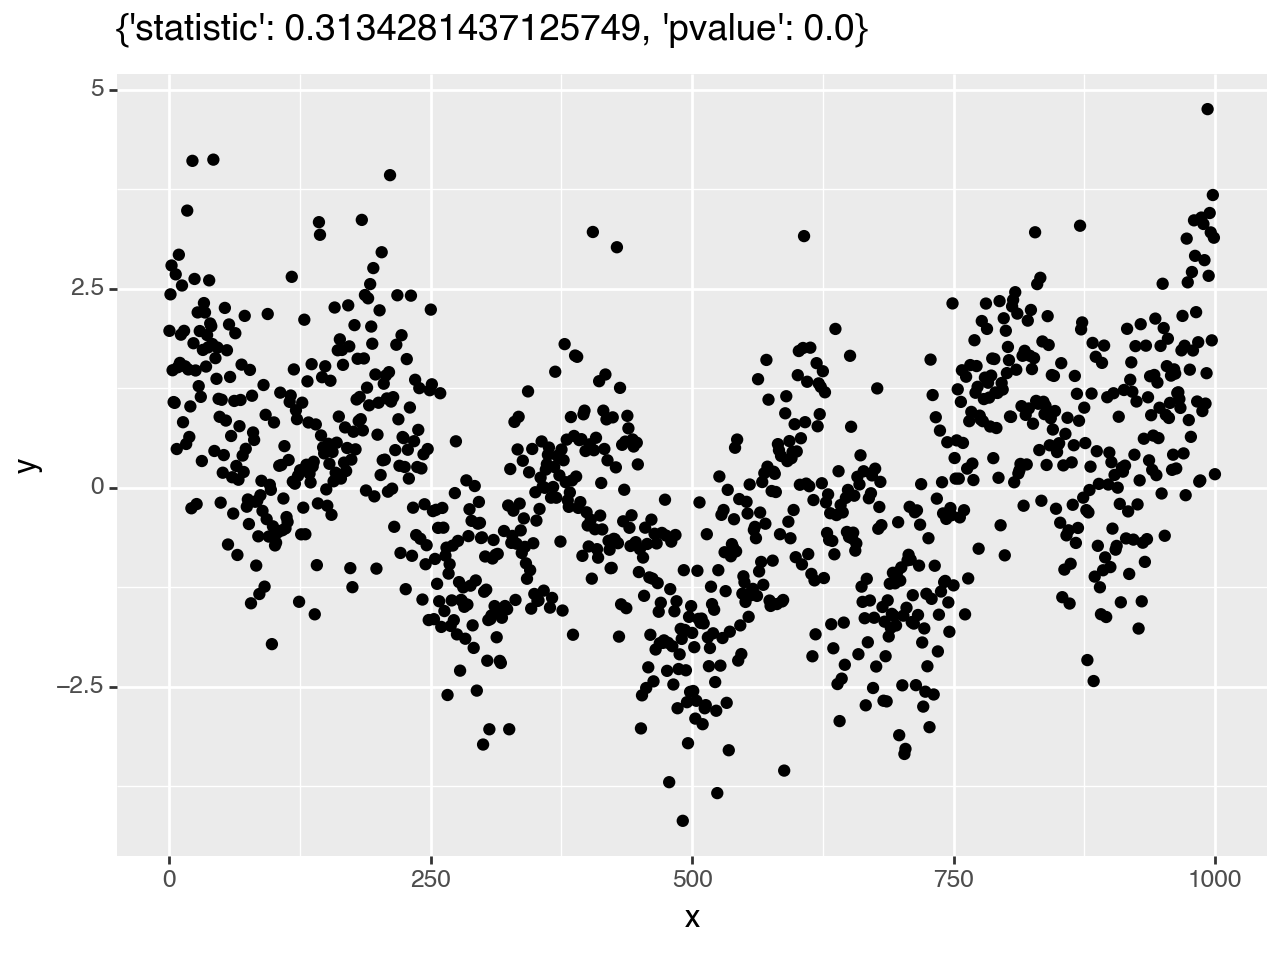

<Figure Size: (640 x 480)>

In [7]:
# When noise_sd = 1, we still discern the effect of x on y

y = add_noise_to_y(df['y'], 1)
ggplot(data=pd.DataFrame({'x': x, 'y': y})) + \
    geom_point(aes(x="x", y="y")) + \
    ggtitle(xicor(x, y))

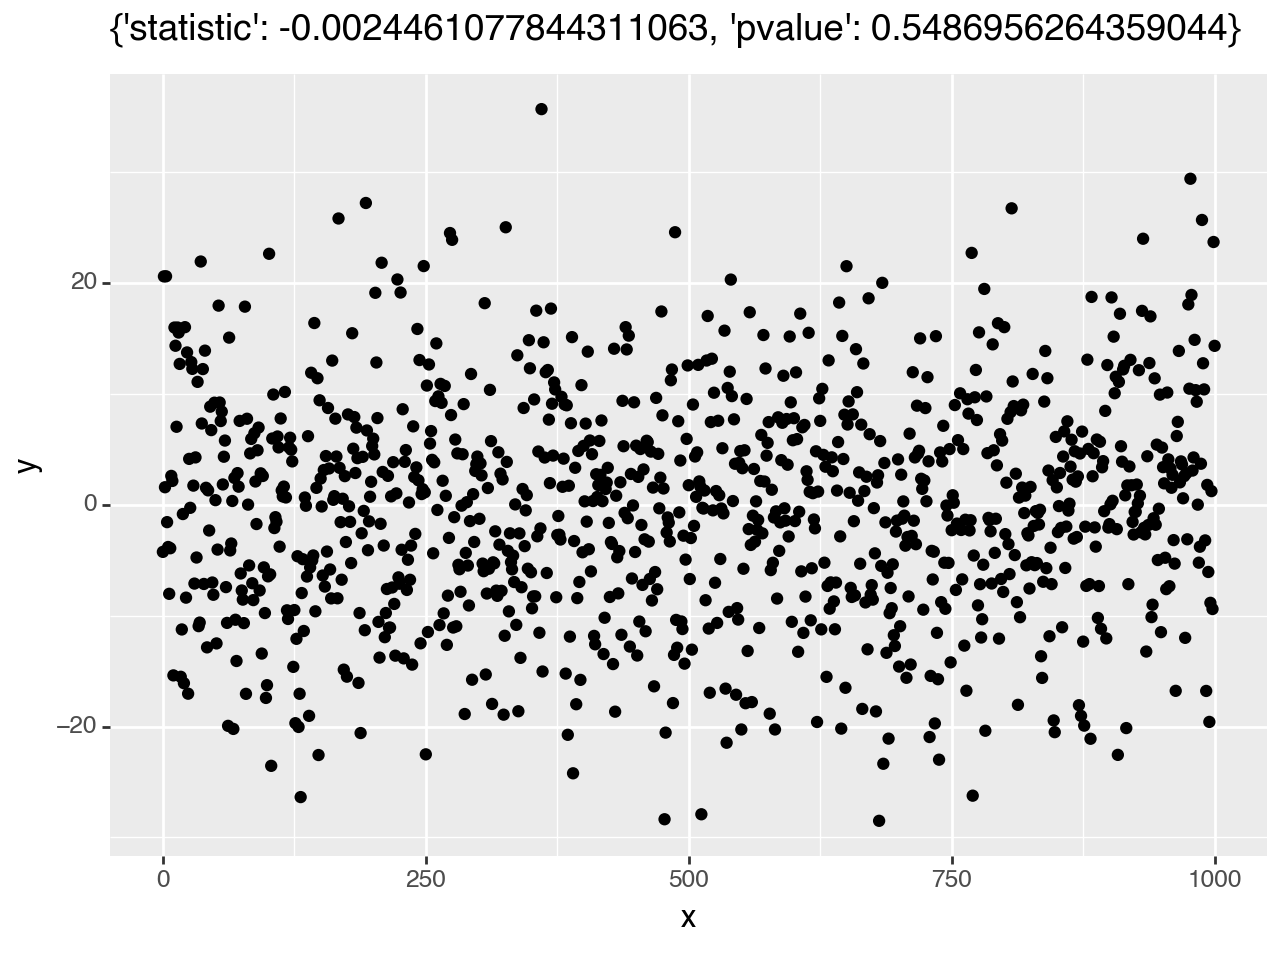

<Figure Size: (640 x 480)>

In [8]:
# In contrast, when noise_sd=10, R ~ 0 (possibly negative)
# With XICOR, R < 0 does not imply anti-correlation;
# rather, it implies no correlation.

y = add_noise_to_y(df['y'], 10)
ggplot(data=pd.DataFrame({'x': x, 'y': y})) + \
    geom_point(aes(x="x", y="y")) + \
    ggtitle(xicor(x, y))

In [9]:
gam.score(x, y)

NameError: name 'gam' is not defined

In [ ]:
y = add_noise_to_y(df['y'], 0.5)
gam = GAM(s(0, n_splines=30)).fit(x, y)
ggplot(data=pd.DataFrame({'x': x, 'y': y})) + \
    geom_line(data=pd.DataFrame({'x': x, 'y': gam.predict(x)}), 
              mapping=aes(x="x", y="y"),
              color="red", size=2, alpha=0.8) + \
    geom_point(aes(x="x", y="y"), size=0.2) + \
    ggtitle("Pearson = " + 
            str(np.round(pearsonr(x, y)[0], 2)) +
            "; Spearman = " + 
            str(np.round(spearmanr(x, y)[0], 2)) +
            "; XICOR = " + 
            str(np.round(xicor(x, y)['statistic'], 2)) +
            "; GAM R2 = " +
            str(np.round(gam.score(x, y), 2)))

## Conclusion

This notebook presents a novel nonlinear correlation coefficient which, unlike Spearman's R, does not assume monotonicity. My [repo](https://github.com/rtlemos/models/blob/main/nonlinear_r/xicor.py) contains the Python version of the original R code in package XICOR (using asymptotic p-values only).

> References:
>
>    [1] Chatterjee S (2021). A new coefficient of correlation. JASA 116:536, 2009-2022, DOI: 10.1080/01621459.2020.1758115
>
>    [2] Chatterjee S, Holmes S (2023). XICOR: Robust and generalized correlation coefficients. https://github.com/spholmes/XICOR, https://CRAN.R-project.org/package=XICOR.